In [50]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import os

In [51]:
import random
seed = 20
random.seed(seed)

In [52]:
data = pd.read_csv(os.getcwd() + "/data.csv")

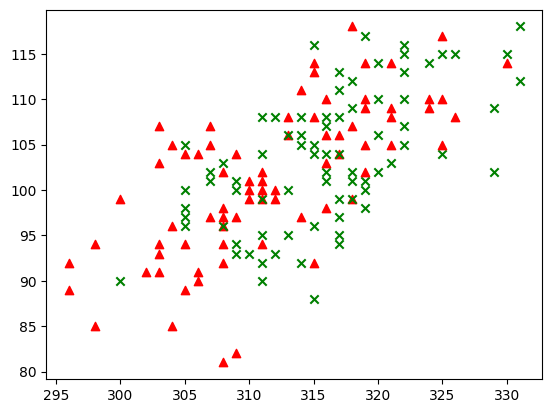

In [53]:
data.columns = data.columns.str.lower().str.replace(' ', '_')
string_columns = list(data.dtypes[data.dtypes == 'object'].index)
for col in string_columns:
    data[col] = data[col].str.lower().str.replace(' ', '_')
data.rename(columns={'toefl/ielts': 'toefl'}, inplace=True)
data_clean_cols = data[['status', 'gre', 'toefl']].dropna()
data_clean = data_clean_cols[data_clean_cols['toefl'] > 10].drop_duplicates()
points = []
for i in range(data_clean.shape[0]):
    gre_value = data_clean['gre'].values[i]
    toefl_value = data_clean['toefl'].values[i]
    status_value = data_clean['status'].values[i]
    points.append((gre_value, toefl_value, status_value))
for point in points:
    if point[2] == 'admit':
        plt.scatter(point[0], point[1], c = 'g', marker = 'x')
    elif point[2] == 'reject':
        plt.scatter(point[0], point[1], c = 'r', marker = '^')
plt.show()

In [54]:
split = 0.8
num_train_points = round(split * len(points))
num_test_points = len(points) - num_train_points
train_points = random.sample(points, num_train_points)
test_points = [point for point in points if point not in train_points]
test_points_features = [(point[0], point[1]) for point in test_points]
test_classes = [point[2] for point in test_points]

In [55]:
def get_test_point_classes(test_classes):
    test_points_classes = []
    for cls in test_classes:
        if cls == 'admit':
            test_points_classes.append(1)
        elif cls == 'reject':
            test_points_classes.append(0)
        else:
            raise
    return test_points_classes

In [56]:
test_points_classes = get_test_point_classes(test_classes)

In [57]:
def get_stats(points):
    class1_points = []
    class2_points = []    
    for point in points:
        if point[2] == 'admit':
            class1_points.append(point)
        elif point[2] == 'reject':
            class2_points.append(point)    
        else:
            raise
    feature1_class1 = [c1_point[0] for c1_point in class1_points]
    feature2_class1 = [c1_point[1] for c1_point in class1_points]
    feature1_class2 = [c2_point[0] for c2_point in class2_points]
    feature2_class2 = [c2_point[1] for c2_point in class2_points]
    mean1 = [np.mean(feature1_class1), np.mean(feature2_class1)]
    mean2 = [np.mean(feature1_class2), np.mean(feature2_class2)]
    data1 = np.array([feature1_class1,feature2_class1])
    cov1 = np.cov(data1,bias=True)
    data2 = np.array([feature1_class2,feature2_class2])
    cov2 = np.cov(data2,bias=True)
    return [(mean1, mean2), (cov1, cov2)]

In [58]:
stats = get_stats(train_points)

In [59]:
def normal_multivariate(x, mean, cov):
    numerator = np.exp(-1/2*(x - mean).T.dot(np.linalg.inv(cov)).dot(x-mean))
    denominator = np.sqrt((2*np.pi)**2 * np.linalg.det(cov))
    return (numerator / denominator)

In [60]:
def run(stats, prob_class1, prob_class2, samples):
    means = stats[0]
    cov = stats[1]
    mean1 = means[0]
    mean2 = means[1]
    cov1 = cov[0]
    cov2 = cov[1]
    data1 = np.random.multivariate_normal(mean1, cov1, int(prob_class1 * samples)).T
    data2 = np.random.multivariate_normal(mean2, cov2, int(prob_class2 * samples)).T
    data = np.concatenate((data1, data2), axis=1)
    probs = np.zeros((samples, 2))
    probs[:, 0] = np.apply_along_axis(normal_multivariate, 0, data, mean1, cov1) * prob_class1
    probs[:, 1] = np.apply_along_axis(normal_multivariate, 0, data, mean2, cov2) * prob_class2
    labels = np.argmax(probs, axis=1)
    class1 = data[:, labels==0]
    class2 = data[:, labels==1]
    plt.plot(class1[0, :], class1[1, :], "go", label= "admit")
    plt.plot(class2[0, :], class2[1, :], "ro", label= "reject")
    plt.legend(loc='upper left')
    plt.title("Predicted classes with Bayes Classifier")
    plt.show()

In [61]:
def get_accuracy(actual, prediction):
    assert len(actual) == len(prediction)
    n = len(prediction)
    count = 0
    for i in range(n):
        if actual[i] == prediction[i]:
            count += 1
    print("Accuracy: {}".format(count/n)) 

In [62]:
def run_test(test_points, test_points_classes, stats, prob_class1, prob_class2):
    samples = len(test_points)
    probs = np.zeros((samples, 2))
    means = stats[0]
    cov = stats[1]
    mean1 = means[0]
    mean2 = means[1]
    cov1 = cov[0]
    cov2 = cov[1]
    data = np.array([[p[0] for p in test_points], [p[1] for p in test_points]])
    probs = np.zeros((samples, 2))
    probs[:, 0] = np.apply_along_axis(normal_multivariate, 0, data, mean1, cov1) * prob_class1
    probs[:, 1] = np.apply_along_axis(normal_multivariate, 0, data, mean2, cov2) * prob_class2
    labels = np.argmax(probs, axis=1)
    get_accuracy(labels, test_points_classes)
    class1 = data[:, labels==0]
    class2 = data[:, labels==1]
    plt.plot(class1[0, :], class1[1, :], "go", label= "admit")
    plt.plot(class2[0, :], class2[1, :], "ro", label= "reject")
    plt.legend(loc='upper left')
    plt.title("Predicted classes with Bayes classifier for Test Data")
    plt.show()

In [63]:
prob_c1 = 0.5
prob_c2 = 1 - prob_c1
dense_samples = 10000

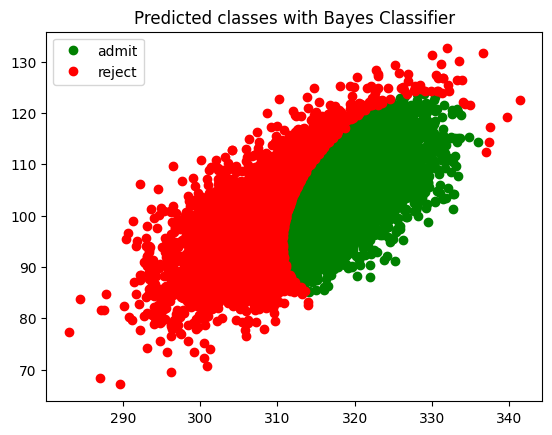

In [64]:
run(stats, prob_c1, prob_c2, dense_samples)

Accuracy: 0.5161290322580645


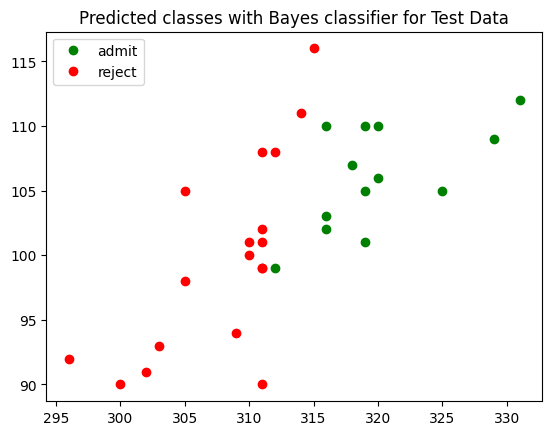

In [65]:
run_test(test_points_features, test_points_classes, stats, prob_c1, prob_c2)